<a href="https://colab.research.google.com/github/mshsu/probasets/blob/main/notebooks/actuarial_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actuarial Demo

## Setup

In [31]:
!pip install symbulate --quiet
!pip install rpy2==3.5.1 --quiet

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from symbulate import *
from scipy.stats import weibull_min, pareto

In [3]:
warnings.filterwarnings('ignore')

In [4]:
%load_ext rpy2.ipython

In [14]:
%%R
if (!require("MASS")) install.packages("MASS")
if (!require("fitdistrplus")) install.packages("fitdistrplus")
if (!require("actuar")) install.packages("actuar")

In [15]:
%%R
library(MASS)
library(fitdistrplus)
library(actuar)

## Microsoft ML Length of Stay Data

In [6]:
stay = pd.read_csv("https://mshsu.github.io/probasets/data/LengthOfStay.csv")
stay

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1/28/2012,3,M,0,0,0,0,0,0,...,171.422555,12.0,0.650323,30.063069,80,6.5,1,2/3/2012,B,6
99996,99997,8/6/2012,0,M,0,0,0,0,0,0,...,122.342450,12.0,1.521424,28.969548,61,6.5,1,8/7/2012,B,1
99997,99998,7/23/2012,1,M,0,0,1,0,0,0,...,108.288106,12.0,1.025677,26.354919,61,6.9,1,7/27/2012,C,4
99998,99999,12/19/2012,0,M,0,0,0,0,0,0,...,111.750731,16.0,1.035400,29.193462,59,5.6,1,12/23/2012,B,4


### Length of Stay - Weibull Model

In [7]:
los = stay['lengthofstay']

In [8]:
%%R -i los
fitdistr(los, "weibull")$estimate

   shape    scale 
1.765541 4.505072 


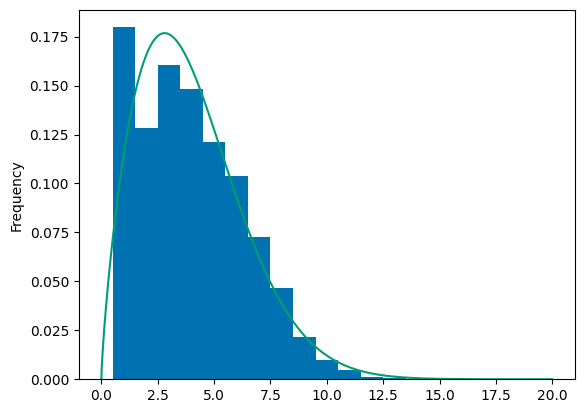

In [9]:
bin_edges=[i+0.5 for i in list(range(min(los)-1, max(los)+1, 1))]
los.plot.hist(bins=bin_edges, density=True)

x = np.linspace(0, 20, 1000)
pdf = weibull_min.pdf(x, 1.765541045, scale = 4.505072181)
plt.plot(x, pdf)
plt.show()

### Discharges per Day - Poisson Model

In [42]:
# Get frequency of appropriate discharges by date
df_counts = pd.to_datetime(stay['discharged']).value_counts().to_frame().reset_index().rename(columns={"index": "date", "discharged": "freq"})
df_counts = df_counts.sort_values(by="date", ignore_index=True)

# However, the df_counts we just generated doesn't contain days with 0 discharges.
# We need to fix this by generating rows for dates with 0 discharges.
# First, let's find the start and end dates.
start_date = df_counts['date'].min()
end_date = df_counts['date'].max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no discharges
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2012-01-02,45
1,2012-01-03,91
2,2012-01-04,119
3,2012-01-05,157
4,2012-01-06,197
...,...,...
372,2013-01-08,44
373,2013-01-09,23
374,2013-01-10,7
375,2013-01-11,2


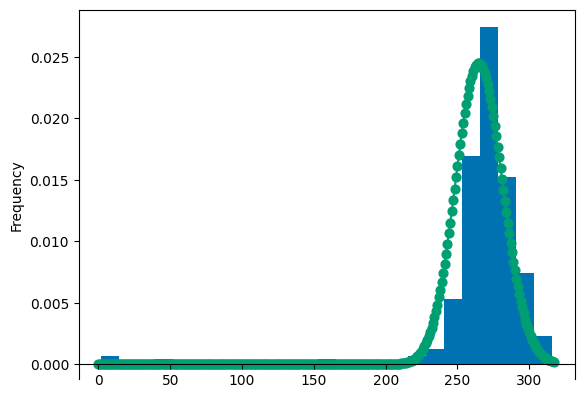

In [47]:
df_counts['freq'].plot.hist(density=True, bins=25)
Poisson(df_counts['freq'].mean()).plot()

### Admits per Day - Poisson Model

In [32]:
# Get frequency of appropriate admits by date
df_counts = pd.to_datetime(stay['vdate']).value_counts().to_frame().reset_index().rename(columns={"index": "date", "vdate": "freq"})
df_counts = df_counts.sort_values(by="date", ignore_index=True)

# However, the df_counts we just generated doesn't contain days with 0 admits.
# We need to fix this by generating rows for dates with 0 admits.
# First, let's find the start and end dates.
start_date = df_counts['date'].min()
end_date = df_counts['date'].max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no admits
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2012-01-01,269
1,2012-01-02,250
2,2012-01-03,253
3,2012-01-04,247
4,2012-01-05,273
...,...,...
361,2012-12-27,292
362,2012-12-28,248
363,2012-12-29,269
364,2012-12-30,302


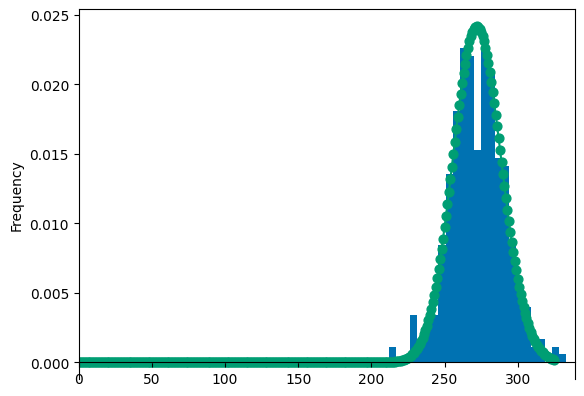

In [33]:
df_counts['freq'].plot.hist(density=True, bins=25)
Poisson(df_counts['freq'].mean()).plot()

## CMS Synthetic Beneficiary Aggregate Claims Data

In [17]:
claims = pd.read_csv("https://mshsu.github.io/probasets/data/Insurance.csv")
claims

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_DEATH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,BENE_ESRD_IND,SP_STATE_CODE,BENE_COUNTY_CD,BENE_HI_CVRAGE_TOT_MONS,BENE_SMI_CVRAGE_TOT_MONS,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,000022FFDB0BE2C7,19381001,NaN,1,1,0,24,260,12,12,...,2,0,0,0,0,0,0,0,0,0
1,00007A645AD6821D,19381201,NaN,1,2,Y,11,470,12,12,...,2,0,0,0,0,0,0,550,240,50
2,00015666C914B9F1,19240301,20100101.0,2,1,0,37,80,12,12,...,2,0,0,0,0,0,0,0,0,0
3,00017C6623040FB5,19331201,NaN,1,1,0,5,530,12,12,...,2,0,0,0,0,0,0,20,0,0
4,0002612EC022F8CF,19360701,NaN,1,5,0,5,410,12,12,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112764,FFFD00DED75060B8,19361201,NaN,2,1,0,45,240,12,12,...,2,0,0,0,0,0,0,60,10,0
112765,FFFD9F9F1EB39E23,19381001,NaN,2,2,0,36,810,12,12,...,2,0,0,0,0,0,0,1670,280,0
112766,FFFECD6946904E8D,19740101,NaN,2,1,0,39,10,0,0,...,2,0,0,0,0,0,0,0,0,0
112767,FFFF3BDFEB08B705,19320401,NaN,2,3,0,5,340,12,12,...,2,0,0,0,460,110,0,920,240,0


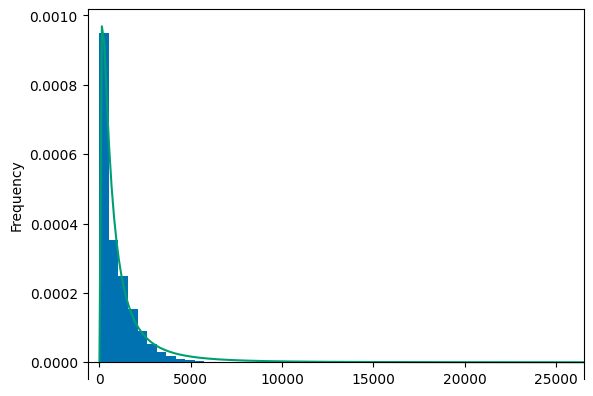

In [28]:
reimb = claims['MEDREIMB_CAR']
reimb.plot.hist(bins = 25, density=True)
reimb_transf = np.log(reimb[reimb != 0])
xbar = reimb_transf.mean()
sd = reimb_transf.std()
LogNormal(xbar, sd).plot()

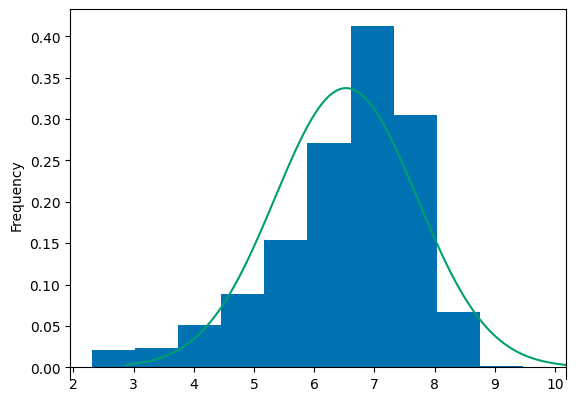

In [29]:
reimb_transf.plot.hist(density = True)
Normal(xbar, sd).plot()